## Figure 2

In [1]:
import mne
import numpy as np
import csv
from glob import glob
from matplotlib import pyplot as plt
from matplotlib import rcParams as rc
from tqdm.notebook import tqdm
rc['pdf.fonttype'] = 42
plt.style.use('seaborn')

In [2]:
# Change these path for running the notebook locally
eeg_data_path = '/path/to/dataset/' # downloadable from OSF: https://doi.org/10.17605/OSF.IO/FNRD9
git_path  = '/path/to/git/speaker_induced_suppression_EEG/'

In [3]:
perception_color = '#117733'
production_color = '#332288'
predictable_color = '#ddcc77'
unpredictable_color = '#aa4499'
picks = ['F1','Fz','F2','FC1','FCz','FC2','C1','Cz','C2']
tmin,tmax = -1.5, 3.5
baseline=(None,0)
reject_thresh = 10 # SD
exclude = 'OP0020'
subjs = np.sort([s[-6:] for s in glob(f'{git_path}eventfiles/*') if 'OP0' in s and exclude not in s])

### Load and epoch data

In [4]:
def interpolate_bads(subj,block,raw,git_path,eeg_data_path):
    '''
    CCA .vhdr files do not include bad channels, so this func interpolates them.
    The end result is each subject has a 64 channel raw arrray, which makes plotting easier
    Filter the data before running this!
    '''
    blockid = subj + '_' + block
    nsamps = len(raw)
    info = mne.io.read_raw_brainvision(f'{eeg_data_path}OP0001/OP0001_B1/OP0001_B1_cca.vhdr',
                                           preload=False,verbose=False).info
    ch_names = info['ch_names']
    bads = [c for c in ch_names if c not in raw.info['ch_names']]
    if len(bads) > 0:
        new_data = []
        for ch in ch_names:
            if ch in bads:
                print('Interpolating', ch)
                new_data.append(np.zeros((1,nsamps)))
            else:
                new_data.append(raw.get_data(picks=ch)[0])
        raw = mne.io.RawArray(np.vstack(new_data),info)
        raw.info['bads'] = bads
        raw.interpolate_bads()
    else:
        print(subj, 'has no bads.')
    return raw
def sem_evoked(evoked):
    '''
    calculates standard error margin across events(evoked)
    evoked should have shape (channels,samples)
    '''
    sem_below = np.nanmean(evoked,axis=0) - (np.nanstd(evoked,axis=0)/np.sqrt(evoked.shape[0]))
    sem_above = np.nanmean(evoked,axis=0) + (np.nanstd(evoked,axis=0)/np.sqrt(evoked.shape[0]))
    return sem_below/1e-6, sem_above/1e-6

In [5]:
raws, spkr_epochs, mic_epochs, spkr_resp, mic_resp = dict(), dict(), dict(), dict(), dict()
conditions = ['el','sh','all']
channels = ['spkr', 'mic']
conditions
subj_bar = tqdm(subjs)
for s in subj_bar:
    spkr_epochs[s], mic_epochs[s], spkr_resp[s], mic_resp[s] = dict(), dict(), dict(), dict()
    if s != 'OP0002':
        block = 'B1'
    else:
        block = 'B2'
    blockid = s + '_' + block
    raw_path = f'{eeg_data_path}{s}/{blockid}/{blockid}_cca.vhdr'
    raw = mne.io.read_raw_brainvision(raw_path,preload=True,verbose=False)
    raw.filter(l_freq=1,h_freq=30,verbose=False)
    raws[s] = interpolate_bads(s,block,raw,git_path,eeg_data_path)
    for ch in channels:
        spkr_epochs[s][ch], mic_epochs[s][ch], spkr_resp[s][ch], mic_resp[s][ch] = dict(), dict(), dict(), dict()
        for co in conditions:
            subj_bar.set_description(f'Epoching {s} {ch} {co}')
            if s in ['OP0015','OP0016']: # mtpl blocks
                events = []
                for b in ['B1','B2']: 
                    event_file = f'{git_path}eventfiles/{s}/{s}_{b}/{s}_{b}_{ch}_sn_{co}.txt'
                    if b == 'B2':
                        b2_fpath = raw_path = f'{eeg_data_path}{s}/{s}_B1/{s}_B1_downsampled.vhdr'
                        b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)
                        block_shift = b2_raw.last_samp
                    else:
                        block_shift = 0
                    with open(event_file, 'r') as my_csv:
                        csvReader = csv.reader(my_csv, delimiter='\t')
                        for row in csvReader:
                            onset = int((float(row[0])*128)+block_shift)
                            offset = int((float(row[1])*128)+block_shift)
                            sn_id = int(row[2])
                            events.append([onset,offset,sn_id])
                events = np.array(events,dtype=int)
            else:
                event_file = f'{git_path}eventfiles/{s}/{blockid}/{blockid}_{ch}_sn_{co}.txt'
                events = []
                with open(event_file, 'r') as my_csv:
                    csvReader = csv.reader(my_csv, delimiter='\t')
                    for row in csvReader:
                        onset = int((float(row[0])*128))
                        offset = int((float(row[1])*128))
                        sn_id = int(row[2])
                        events.append([onset,offset,sn_id])
                events = np.array(events,dtype=int)
            reject = mne.Epochs(raws[s], events, tmin=tmin, tmax=tmax,reject=None,
                           baseline=baseline,verbose=False)
            reject = reject.get_data(picks=picks)
            reject = dict(eeg=np.std(reject)*(reject_thresh*2))
            epochs = mne.Epochs(raws[s],events,tmin=tmin,tmax=tmax,reject=reject,
                                   baseline=baseline,verbose=False)
            if ch == 'spkr':
                spkr_epochs[s][ch][co] = epochs
                spkr_resp[s][ch][co] = epochs.get_data(picks=picks)
            if ch == 'mic':
                mic_epochs[s][ch][co] = epochs
                mic_resp[s][ch][co] = epochs.get_data(picks=picks)

  0%|          | 0/20 [00:00<?, ?it/s]

OP0001 has no bads.
Using data from preloaded Raw for 202 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 202 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3', 'POz']
    Rejecting  epoch based on EEG : ['T7']
8 bad epochs dropped
Using data from preloaded Raw for 202 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 202 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 404 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 404 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['PO3']
    Re

0 bad epochs dropped
Using data from preloaded Raw for 398 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['P6']
3 bad epochs dropped
Using data from preloaded Raw for 200 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 200 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 200 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 200 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['POz']
    Rejecting  epoch based on EEG : ['POz']
2 bad epochs dropped
Using data from preloaded Raw for 400 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 400 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['POz']
    Rejecting  epoch based on EEG : ['POz']
2 

    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'F3', 'F7', 'FT10', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FC3', 'FCz', 'F6', 'F2', 'AF4']
    Rejecting  epoch based on EEG : ['F8', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
12 bad epochs dropped
OP0006 has no bads.
Using data from preloaded Raw for 149 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 149 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'PO3', 'PO4']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'POz', 'PO4', 'P6']
    Reje

    Rejecting  epoch based on EEG : ['Fp1', 'F3', 'O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['Pz', 'O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2']
    Rejecting  epoch based on EEG : ['Fp1', 'FT9', 'Pz', 'O2', 'P4', 'P8', 'Fp2', 'AF7', 'P5', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'P8', 'PO3', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'PO4']
    Rejecting  epoch based on EEG : ['Pz', 'P3', 'O2', 'P4', 'P1', 'P5', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'POz', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'P6']
    Rejecting 

    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'POz', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'P8', 'PO3', 'POz', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'POz', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'PO4']
    Rejecting  epoch based on EEG : ['O2', 'PO4']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'P8', 'PO3', 'POz', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['Fz', 'Pz', 'O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2']
    Rejecting  epoch based on EEG : ['O2', 'PO4']
    Rejecti

    Rejecting  epoch based on EEG : ['Pz', 'P3', 'O2', 'P4', 'P1', 'PO3', 'POz', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['Oz', 'O2', 'P4', 'PO3', 'POz', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['F3', 'O2', 'P4', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6']
    Rejecting  epoch bas

    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'F3', 'FC1', 'CP5', 'O2', 'P4', 'Fp2', 'F1', 'FC3', 'CP3', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'AF8']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'POz', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'POz', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'PO4']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'POz', 'PO4']
    Rejecting  epoch based on EEG : ['O2', 'P4

    Rejecting  epoch based on EEG : ['Pz', 'O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2']
    Rejecting  epoch based on EEG : ['O2', 'PO4']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'POz', 'PO4', 'PO8', 'P6', 'P2']
    Rejecting  epoch based on EEG : ['Pz', 'O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6']
    Rejecting  e

    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'P6']
    Rejecting  epoch based on EEG : ['P6']
    Rejecting  epoch based on EEG : ['Pz', 'O2', 'P4', 'PO3', 'POz', 'PO4', 'PO8', 'P6']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4']
    Rejecting  epoch based on EEG : ['O2', 'PO4']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'PO4', 'P6']
34 bad epochs dropped
Using data from preloaded Raw for 300 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 300 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['AF4']
    Rejecting  epoch based on EEG : ['O2', 'PO4']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['AF3']
    Rejecting  epoch based on EEG : ['FC5', 'C6']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3']


0 bad epochs dropped
Using data from preloaded Raw for 149 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['FC6', 'F4', 'F8', 'F6', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FT10', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF8']
5 bad epochs dropped
Using data from preloaded Raw for 149 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 149 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['F8', 'F6']
4 bad epochs dropped
Using data from preloaded Raw for 298 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 298 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['T7']
    

1 bad epochs dropped
Using data from preloaded Raw for 298 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 298 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
3 bad epochs dropped
Using data from preloaded Raw for 150 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 150 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'F3', 'F7', 'FT10', 'FC6', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC4', 'FT8', 'F6', 'F2', 'AF4']
    Rejecting  epoch based on EEG : ['F7', 'FC5', 'FT7']
3 bad epochs dropped
Using data from preloaded Raw for 150 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 150 events and 641 original time points ...
    Re

    Rejecting  epoch based on EEG : ['Fp1', 'FT9', 'O2', 'FT10', 'Fp2', 'AF3', 'FT7', 'PO7', 'PO3', 'PO4', 'PO8', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'O1', 'Oz', 'O2', 'Fp2', 'AF7', 'AF3', 'FT7', 'PO7', 'PO3', 'POz', 'PO4', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'FT9', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'FT7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'FT8', 'F6', 'F2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'FT10', 'Fp2', 'AF3', 'PO7', 'PO3', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'O2', 'P4', 'P8', 'Fp2', 'AF7', 'AF3', 'POz', 'PO4', 'PO8', 'P6', 'AF8']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF3', 'PO4', 'PO8', 'AF8']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['O2', 'PO4', 'PO8']
    Rejecting  epoch 

    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF3', 'PO4', 'AF8']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['P4', 'PO4']
    Rejecting  epoch based on EEG : ['PO4', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'O2', 'P4', 'P8', 'Fp2', 'AF3', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF3']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['Fp1', 'O2', 'Fp2', 'AF3', 'PO4', 'PO8', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'O2', 'P4', 'Fp2', 'PO3', 'POz', 'PO4', 'PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'FT9', 'FT10', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F5', 'FT7', 'PO3', 'POz', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['Fp2', 'PO4']
    Rejecting  epoch 

127 bad epochs dropped
Using data from preloaded Raw for 149 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 149 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['T8', 'FT7', 'POz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'POz', 'PO8', 'P2']
    Rejecting  epoch based on EEG : ['POz']
    Rejecting  epoch based on EEG : ['FT7']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9', 'FT10']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['FT9', 'FT10']
    Rejecting  epoch based on EEG : ['FT7']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['FT7', 'POz', 'P2']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['FT7']
    Rejecting  epoch based on EEG : ['Fp2', 'FT7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF3']

    Rejecting  epoch based on EEG : ['Fp1', 'O1', 'Oz', 'O2', 'P4', 'Fp2', 'AF7', 'AF3', 'PO3', 'POz', 'PO4', 'PO8', 'AF8']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['FT9', 'FT7']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'Fp2', 'POz', 'PO4', 'PO8']
    Rejecting  epoch based on EEG : ['FT7']
    Rejecting  epoch based on EEG : ['Fp1', 'O2', 'P4', 'Fp2', 'AF7', 'AF3', 'FT7', 'PO3', 'POz', 'PO4', 'PO8', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'O2', 'P4', 'P8', 'Fp2', 'AF7', 'AF3', 'AFz', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'O1', 'Oz', 'O2', 'P4', 'Fp2', 'AF7', 'AF3', 'FT7', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'O2', 'P4', 'P8', 'Fp2', 'AF7', 'AF3', 'PO7', 'PO3', 'PO4', 'PO8', 'P6', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'O2', 'P4', 'P8', 'Fp2', 'FT7', 'POz', 'PO4', 'PO8', 'P6', 'AF8']
    Rejecting  epoch based on EEG : ['

    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'FT9', 'O1', 'O2', 'P4', 'P8', 'FT10', 'Fp2', 'AF3', 'P5', 'PO7', 'PO3', 'PO4', 'PO8', 'P6', 'AF8']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['Fp1', 'O1', 'O2', 'P4', 'P8', 'Fp2', 'AF7', 'AF3', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'O2', 'P4', 'FT10', 'Fp2', 'AF3', 'POz', 'PO4', 'PO8', 'AF8']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['FT7']
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'FT9', 'T7', 'O2', 'P8', 'FT10', 'Fp2', 'AF3', 'FT7', 'PO4', 'PO8', 'P6', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'FT9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'CP2', 'Cz', 'FT10', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'FT7', 'FCz', 'C1', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'FT8', 'F6', 'F2', 

    Rejecting  epoch based on EEG : ['AF4']
    Rejecting  epoch based on EEG : ['FT8']
    Rejecting  epoch based on EEG : ['AF4']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['AF4']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['AF4']
    Rejecting  epoch based on EEG : ['AF4']
9 bad epochs dropped
Using data from preloaded Raw for 150 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 150 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['FT8']
    Rejecting  epoch based on EEG : ['FT8']
    Rejecting  epoch based on EEG : ['AF4']
    Rejecting  epoch based on EEG : ['AF4']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['AF4']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['AF4']
9 bad epochs dropped
Using data from preloaded Raw for 300

/tmp/ipykernel_11083/52083338.py:27: RuntimeWarning: No coordinate information found for channels ['spkr', 'mic', 'vEOG', 'hEOG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)
/tmp/ipykernel_11083/52083338.py:27: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['spkr', 'mic', 'vEOG', 'hEOG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)
/tmp/ipykernel_11083/52083338.py:27: RuntimeWarning: No coordinate information found for channels ['spkr', 'mic', 'vEOG', 'hEOG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)
/tmp/ipykernel_11

0 bad epochs dropped
Using data from preloaded Raw for 99 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 237 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 237 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['FT8']
1 bad epochs dropped


/tmp/ipykernel_11083/52083338.py:27: RuntimeWarning: No coordinate information found for channels ['spkr', 'mic', 'vEOG', 'hEOG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)
/tmp/ipykernel_11083/52083338.py:27: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['spkr', 'mic', 'vEOG', 'hEOG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)
/tmp/ipykernel_11083/52083338.py:27: RuntimeWarning: No coordinate information found for channels ['spkr', 'mic', 'vEOG', 'hEOG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)


Using data from preloaded Raw for 142 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 142 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['FC3']
1 bad epochs dropped
Using data from preloaded Raw for 100 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 100 events and 641 original time points ...
0 bad epochs dropped


/tmp/ipykernel_11083/52083338.py:27: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['spkr', 'mic', 'vEOG', 'hEOG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)
/tmp/ipykernel_11083/52083338.py:27: RuntimeWarning: No coordinate information found for channels ['spkr', 'mic', 'vEOG', 'hEOG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)
/tmp/ipykernel_11083/52083338.py:27: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['spkr', 'mic', 'vEOG', 'hEOG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creati

Using data from preloaded Raw for 242 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 242 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['FT9', 'FC3']
1 bad epochs dropped


/tmp/ipykernel_11083/52083338.py:27: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['spkr', 'mic', 'vEOG', 'hEOG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)


Interpolating FC5
Interpolating T8
Interpolating FT7
Interpolating P5
Creating RawArray with float64 data, n_channels=64, n_times=522687
    Range : 0 ... 522686 =      0.000 ...  4083.223 secs
Ready.
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 4 sensors
Using data from preloaded Raw for 146 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 146 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'FC5', 'FC1', 'F4', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'FC3', 'F2', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'Cz', 'C4', 'T8', 'F

/tmp/ipykernel_11083/52083338.py:27: RuntimeWarning: No coordinate information found for channels ['spkr', 'mic', 'vEOG', 'hEOG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)
/tmp/ipykernel_11083/52083338.py:27: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['spkr', 'mic', 'vEOG', 'hEOG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)
/tmp/ipykernel_11083/52083338.py:27: RuntimeWarning: No coordinate information found for channels ['spkr', 'mic', 'vEOG', 'hEOG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)


Using data from preloaded Raw for 149 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 149 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'FC2', 'F4', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'FCz', 'C1', 'C5', 'F6', 'F2', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC5', 'FC1', 'T8', 'FC6', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'FC4', 'FT8', 'F6', 'F2', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['Pz', 'POz']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7

/tmp/ipykernel_11083/52083338.py:27: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['spkr', 'mic', 'vEOG', 'hEOG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)
/tmp/ipykernel_11083/52083338.py:27: RuntimeWarning: No coordinate information found for channels ['spkr', 'mic', 'vEOG', 'hEOG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)
/tmp/ipykernel_11083/52083338.py:27: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['spkr', 'mic', 'vEOG', 'hEOG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creati

Using data from preloaded Raw for 295 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 295 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'FC5', 'FC1', 'F4', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'FC3', 'F2', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'FC2', 'F4', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'FCz', 'C1', 'C5', 'FC4', 'F6', 'F2', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC5', 'FC1', 'T8', 'FC6', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'FC4', 'FT8', 'F6', 'F2', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based 

/tmp/ipykernel_11083/52083338.py:27: RuntimeWarning: No coordinate information found for channels ['spkr', 'mic', 'vEOG', 'hEOG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)
/tmp/ipykernel_11083/52083338.py:27: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['spkr', 'mic', 'vEOG', 'hEOG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)
/tmp/ipykernel_11083/52083338.py:27: RuntimeWarning: No coordinate information found for channels ['spkr', 'mic', 'vEOG', 'hEOG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)


Using data from preloaded Raw for 141 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 141 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'FC5', 'AF7', 'AF3', 'AFz', 'F1', 'F5']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'Cz', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'FCz', 'C1', 'C5', 'C2', 'FC4', 'F6', 'F2', 'AF4', 'AF8']
2 bad epochs dropped
Using data from preloaded Raw for 298 events and 641 original time points ...


/tmp/ipykernel_11083/52083338.py:27: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['spkr', 'mic', 'vEOG', 'hEOG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)
/tmp/ipykernel_11083/52083338.py:27: RuntimeWarning: No coordinate information found for channels ['spkr', 'mic', 'vEOG', 'hEOG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  b2_raw = mne.io.read_raw_brainvision(b2_fpath,preload=True,verbose=False)
/tmp/ipykernel_11083/52083338.py:27: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['spkr', 'mic', 'vEOG', 'hEOG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creati

0 bad epochs dropped
Using data from preloaded Raw for 298 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['C5']
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'FC5', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FC3']
    Rejecting  epoch based on EEG : ['Oz', 'O2', 'PO4']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'Cz', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'FCz', 'C1', 'C2', 'FC4', 'FT8', 'F6', 'F2', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'Cz', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'FCz', 'C1', 'C5', 'CP3', 'C2', 'FC4', 'F6', 'F2', 'AF4', 'AF8']
5 bad epochs dropped
Interpolating TP9
Interpolating FT7
Creating RawArray with float64 data, n_channels=64, n_times=432083
    Range : 0 ... 432082 =      0.000 ...  3375.425 secs
Ready.
Interpolating bad channels
    Automatic

    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['FT9', 'F4']
15 bad epochs dropped
Using data from preloaded Raw for 150 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 150 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
7 bad epochs dropped
Using data from preloaded Raw for 300 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 300 events and 641 origina

    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'F3', 'F7', 'FC1', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['FC4']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['FC6', 'C2']
    Rejecting  epoch based on EEG : ['FC6', 'Fp2', 'C2', 'AF4']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
13 bad epochs dropped
Using data from preloaded Raw for 300 events and 641 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 300 events and 641 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'F3', 'FC5', 'FC6', 'F8', 'Fp2', 'AF7', 'F1', 'F5', 'C1', 'C2', 'FC4', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 

In [6]:
# Concatenate trials by first averaging across event ID
times = spkr_resp['OP0001']['spkr']['all'].shape[2]
spkr_evoked = np.zeros((len(subjs),len(picks),times))
mic_evoked = np.zeros((len(subjs),len(picks),times))
el_evoked = np.zeros((len(subjs),len(picks),times))
sh_evoked = np.zeros((len(subjs),len(picks),times))
for i,s in enumerate(subjs):
    e = spkr_epochs[s]['spkr']['all'].average(picks=picks,by_event_type=True)
    spkr_evoked[i] = mne.combine_evoked(e,'nave').get_data()
    e = mic_epochs[s]['mic']['all'].average(picks=picks,by_event_type=True)
    mic_evoked[i] = mne.combine_evoked(e,'nave').get_data()
    e = spkr_epochs[s]['spkr']['el'].average(picks=picks,by_event_type=True)
    el_evoked[i] = mne.combine_evoked(e,'nave').get_data()
    e = spkr_epochs[s]['spkr']['sh'].average(picks=picks,by_event_type=True)
    sh_evoked[i] = mne.combine_evoked(e,'nave').get_data()
# Take the difference wave within subject at each event ID, then combine
spkr_mic_dw = np.zeros((len(subjs),len(picks),times))
el_sh_dw = np.zeros((len(subjs),len(picks),times))
for i0,s in enumerate(subjs):
    spkr_e = spkr_epochs[s]['spkr']['all'].average(picks=picks,by_event_type=True)
    mic_e = mic_epochs[s]['mic']['all'].average(picks=picks,by_event_type=True)
    el_e = spkr_epochs[s]['spkr']['el'].average(picks=picks,by_event_type=True)
    sh_e = spkr_epochs[s]['spkr']['sh'].average(picks=picks,by_event_type=True)
    subj_dws = []
    for ie, e1 in enumerate(spkr_e):
        spkr_ev_id = e1.comment
        e2 = [x for x in mic_e if x.comment==spkr_ev_id][0]
        subj_dws.append(mne.combine_evoked([e1,e2],[1,-1]))
    spkr_mic_dw[i] = mne.combine_evoked(subj_dws,'nave').get_data()
    subj_dws = []
    for ie, e1 in enumerate(el_e):
        el_ev_id = e1.comment
        e2 = [x for x in sh_e if x.comment==spkr_ev_id][0]
        subj_dws.append(mne.combine_evoked([e1,e2],[1,-1]))
    el_sh_dw[i] = mne.combine_evoked(subj_dws,'nave').get_data()

/tmp/ipykernel_11083/2290730921.py:8: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  e = spkr_epochs[s]['spkr']['all'].average(picks=picks,by_event_type=True)
/tmp/ipykernel_11083/2290730921.py:8: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  e = spkr_epochs[s]['spkr']['all'].average(picks=picks,by_event_type=True)
/tmp/ipykernel_11083/2290730921.py:8: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  e = spkr_epochs[s]['spkr']['all'].average(picks=picks,by_event_type=True)
/tmp/ipykernel_11083/2290730921.py:8: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  e = spkr_epochs[s]['spkr']['all'].average(picks=picks,by_event_type=True)
/tmp/ipykernel_11083/2290730921.py:8: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  e = spkr_epochs[s]['spkr']['all'].average(picks=picks,by_event_type=True)
/tmp/ipykernel_11083/2290730921.py:8: RuntimeWarning: evoked object is empty (based on les

/tmp/ipykernel_11083/2290730921.py:12: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  e = spkr_epochs[s]['spkr']['el'].average(picks=picks,by_event_type=True)
/tmp/ipykernel_11083/2290730921.py:12: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  e = spkr_epochs[s]['spkr']['el'].average(picks=picks,by_event_type=True)
/tmp/ipykernel_11083/2290730921.py:12: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  e = spkr_epochs[s]['spkr']['el'].average(picks=picks,by_event_type=True)
/tmp/ipykernel_11083/2290730921.py:12: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  e = spkr_epochs[s]['spkr']['el'].average(picks=picks,by_event_type=True)
/tmp/ipykernel_11083/2290730921.py:12: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  e = spkr_epochs[s]['spkr']['el'].average(picks=picks,by_event_type=True)
/tmp/ipykernel_11083/2290730921.py:12: RuntimeWarning: evoked object is empty (based on le

/tmp/ipykernel_11083/2290730921.py:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  e = mic_epochs[s]['mic']['all'].average(picks=picks,by_event_type=True)
/tmp/ipykernel_11083/2290730921.py:12: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  e = spkr_epochs[s]['spkr']['el'].average(picks=picks,by_event_type=True)
/tmp/ipykernel_11083/2290730921.py:12: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  e = spkr_epochs[s]['spkr']['el'].average(picks=picks,by_event_type=True)
/tmp/ipykernel_11083/2290730921.py:12: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  e = spkr_epochs[s]['spkr']['el'].average(picks=picks,by_event_type=True)
/tmp/ipykernel_11083/2290730921.py:12: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  e = spkr_epochs[s]['spkr']['el'].average(picks=picks,by_event_type=True)
/tmp/ipykernel_11083/2290730921.py:12: RuntimeWarning: evoked object is empty (based on les

/tmp/ipykernel_11083/2290730921.py:22: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  el_e = spkr_epochs[s]['spkr']['el'].average(picks=picks,by_event_type=True)
/tmp/ipykernel_11083/2290730921.py:22: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  el_e = spkr_epochs[s]['spkr']['el'].average(picks=picks,by_event_type=True)
/tmp/ipykernel_11083/2290730921.py:22: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  el_e = spkr_epochs[s]['spkr']['el'].average(picks=picks,by_event_type=True)
/tmp/ipykernel_11083/2290730921.py:22: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  el_e = spkr_epochs[s]['spkr']['el'].average(picks=picks,by_event_type=True)
/tmp/ipykernel_11083/2290730921.py:22: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  el_e = spkr_epochs[s]['spkr']['el'].average(picks=picks,by_event_type=True)
/tmp/ipykernel_11083/2290730921.py:22: RuntimeWarning: evoked object is emp

/home/kfsh/anaconda3/envs/mne1-1/lib/python3.10/site-packages/mne/evoked.py:956: RuntimeWarning: invalid value encountered in true_divide
  weights = naves / naves.sum()
/tmp/ipykernel_11083/2290730921.py:21: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  mic_e = mic_epochs[s]['mic']['all'].average(picks=picks,by_event_type=True)
/tmp/ipykernel_11083/2290730921.py:22: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  el_e = spkr_epochs[s]['spkr']['el'].average(picks=picks,by_event_type=True)
/tmp/ipykernel_11083/2290730921.py:22: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  el_e = spkr_epochs[s]['spkr']['el'].average(picks=picks,by_event_type=True)
/tmp/ipykernel_11083/2290730921.py:22: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  el_e = spkr_epochs[s]['spkr']['el'].average(picks=picks,by_event_type=True)
/tmp/ipykernel_11083/2290730921.py:22: RuntimeWarning: evoked object is empty (based on le

### Plotting

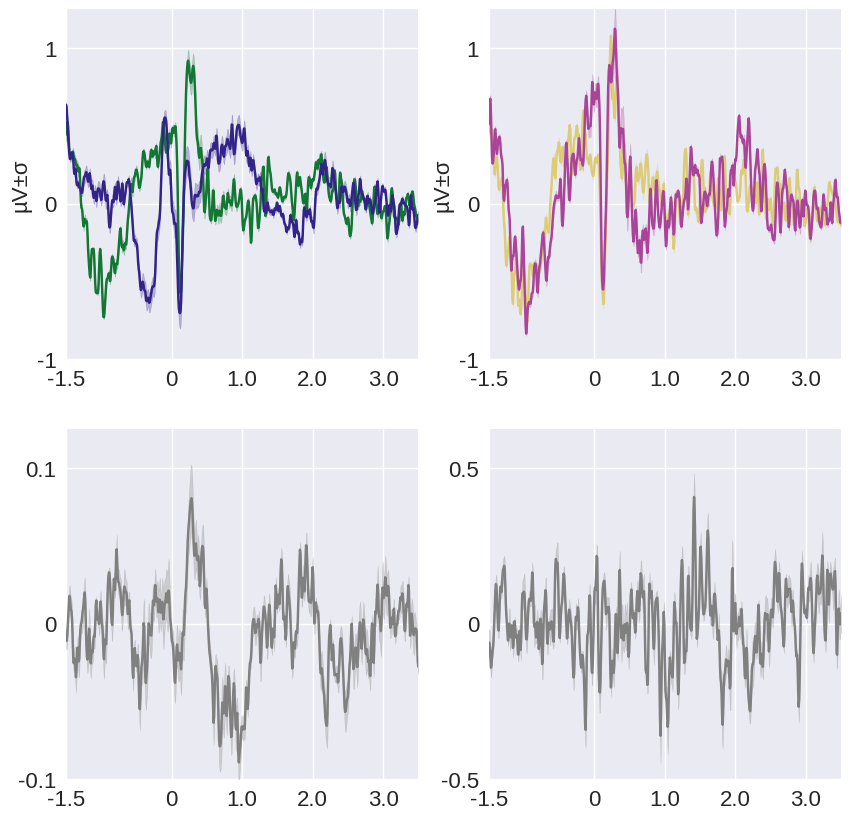

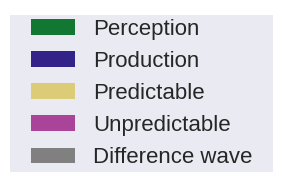

In [7]:
# Panel B
fontsize=16
plt.figure(figsize=(10,10))
x = np.linspace(tmin,tmax,spkr_evoked.shape[2])

plt.subplot(2,2,1)
y1 = np.nanmean(spkr_evoked,axis=0)/1e-6
y1_error_epochs = sem_evoked(np.nanmean(spkr_evoked,axis=0))
y2 = np.nanmean(mic_evoked,axis=0)/1e-6
y2_error_epochs = sem_evoked(np.nanmean(mic_evoked,axis=0)) 
plt.plot(x,y1.mean(0),color=perception_color)
plt.fill_between(x,y1_error_epochs[0],y1_error_epochs[1],color=perception_color,alpha=0.3)
plt.plot(x,y2.mean(0),color=production_color)
plt.fill_between(x,y2_error_epochs[0],y2_error_epochs[1],color=production_color,alpha=0.3)
plt.gca().set_xticks([tmin,0,1.,2.,3.]);
plt.gca().set_xticklabels([tmin,0,1.,2.,3.],fontsize=fontsize);
plt.gca().set_xlim([tmin,tmax])
plt.gca().set_yticks([-1,0,1])
plt.gca().set_yticklabels([-1,0,1], fontsize=fontsize)
plt.gca().set_ylim([-1, 1.25])
plt.ylabel("µV±σ", fontsize=fontsize);

plt.subplot(2,2,2)
y1 = np.nanmean(el_evoked,axis=0)/1e-6
y1_error_epochs = sem_evoked(np.nanmean(el_evoked,axis=0))
y2 = np.nanmean(sh_evoked,axis=0)/1e-6
y2_error_epochs = sem_evoked(np.nanmean(sh_evoked,axis=0)) 
plt.plot(x,y1.mean(0),color=predictable_color)
plt.fill_between(x,y1_error_epochs[0],y1_error_epochs[1],color=predictable_color,alpha=0.3)
plt.plot(x,y2.mean(0),color=unpredictable_color)
plt.fill_between(x,y2_error_epochs[0],y2_error_epochs[1],color=unpredictable_color,alpha=0.3)
plt.gca().set_xticks([tmin,0,1.,2.,3.]);
plt.gca().set_xticklabels([tmin,0,1.,2.,3.],fontsize=fontsize);
plt.gca().set_xlim([tmin,tmax])
plt.gca().set_yticks([-1,0,1])
plt.gca().set_yticklabels([-1,0,1], fontsize=fontsize)
plt.gca().set_ylim([-1, 1.25])
plt.ylabel("µV±σ", fontsize=fontsize);

plt.subplot(2,2,3)
y = np.nanmean(spkr_mic_dw,axis=0)/1e-6
y_error_epochs = sem_evoked(np.nanmean(spkr_mic_dw,axis=0))
plt.plot(x,y.mean(0),color='grey')
plt.fill_between(x,y_error_epochs[0],y_error_epochs[1],alpha=0.3,color='grey')
plt.gca().set_xticks([tmin,0,1.,2.,3.]);
plt.gca().set_xticklabels([tmin,0,1.,2.,3.],fontsize=fontsize);
plt.gca().set_xlim([tmin,tmax])
plt.gca().set_yticks([-.1,0,.1])
plt.gca().set_yticklabels([-.1,0,.1], fontsize=fontsize)
plt.gca().set_ylim([-.1, .125])

plt.subplot(2,2,4)
y = np.nanmean(el_sh_dw,axis=0)/1e-6
y_error_epochs = sem_evoked(np.nanmean(el_sh_dw,axis=0))
plt.plot(x,y.mean(0),color='grey')
plt.fill_between(x,y_error_epochs[0],y_error_epochs[1],alpha=0.3,color='grey')
plt.gca().set_xticks([tmin,0,1.,2.,3.]);
plt.gca().set_xticklabels([tmin,0,1.,2.,3.],fontsize=fontsize);
plt.gca().set_xlim([tmin,tmax])
plt.gca().set_yticks([-.5,0,.5])
plt.gca().set_yticklabels([-.5,0,.5], fontsize=fontsize)
plt.gca().set_ylim([-.5, .625]);

# legend
plt.figure(figsize=(3,2))
plt.bar(0,0,color=perception_color,label="Perception")
plt.bar(0,0,color=production_color,label="Production")
plt.bar(0,0,color=predictable_color,label="Predictable")
plt.bar(0,0,color=unpredictable_color,label="Unpredictable")
plt.bar(0,0,color='grey', label="Difference wave")
plt.grid(False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.legend(fontsize=fontsize,loc='center');
plt.tight_layout()

/tmp/ipykernel_11083/1314614012.py:4: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_spkr_epochs = mne.concatenate_epochs(


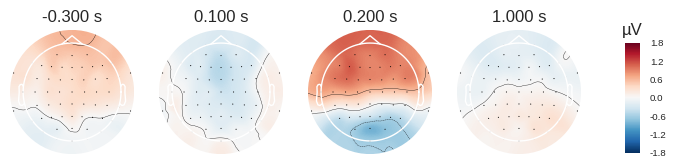

/tmp/ipykernel_11083/1314614012.py:7: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_mic_epochs = mne.concatenate_epochs(


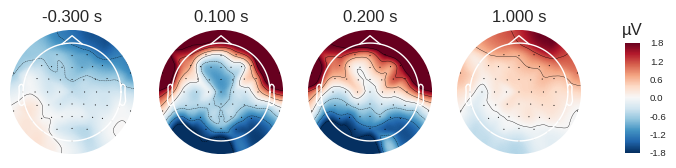

/tmp/ipykernel_11083/1314614012.py:10: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_el_epochs = mne.concatenate_epochs(


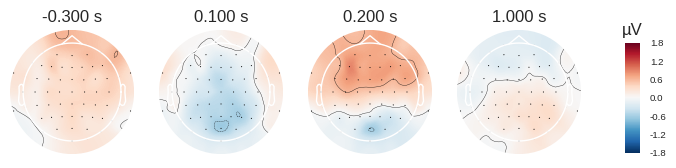

/tmp/ipykernel_11083/1314614012.py:13: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_sh_epochs = mne.concatenate_epochs(


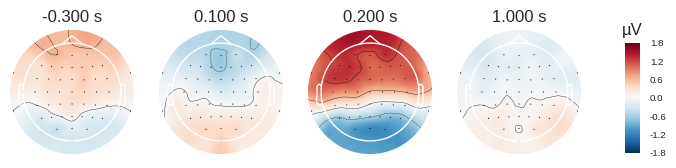

In [8]:
# Panel A
vmin,vmax = -1.8,1.8
topo_times = [-.3, .1, .2, 1.] # based on where the peaks are in the spkr/mic grand avg plots
all_spkr_epochs = mne.concatenate_epochs(
    [spkr_epochs[x]['spkr']['all'] for x in subjs],verbose=False).average()
all_spkr_epochs.plot_topomap(topo_times,vmin=vmin,vmax=vmax);
all_mic_epochs = mne.concatenate_epochs(
    [mic_epochs[x]['mic']['all'] for x in subjs],verbose=False).average()
all_mic_epochs.plot_topomap(topo_times,vmin=vmin,vmax=vmax);
all_el_epochs = mne.concatenate_epochs(
    [spkr_epochs[x]['spkr']['el'] for x in subjs],verbose=False).average()
all_el_epochs.plot_topomap(topo_times,vmin=vmin,vmax=vmax);
all_sh_epochs = mne.concatenate_epochs(
    [spkr_epochs[x]['spkr']['sh'] for x in subjs],verbose=False).average()
all_sh_epochs.plot_topomap(topo_times,vmin=vmin,vmax=vmax);